[![CyVers](https://i.imgur.com/yyhmZET.png)](https://www.cyvers.ai/)

# BlockChain Attack Data Set - Exploratory Data Analysis (EDA)

> Notebook by:
> - Royi Avital Royi@cyverse.com

## Revision History

| Version | Date       | Content / Changes                      |
|---------|------------|----------------------------------------|
| 0.1.000 | 30/06/2022 | First version                          |
|         |            |                                        |

In [1]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Misc
import datetime
import os
from platform import python_version
import random
import warnings

# EDA Tools
import ppscore as pps #<! See https://github.com/8080labs/ppscore -> pip install git+https://github.com/8080labs/ppscore.git

# Machine Learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn import svm, tree
from sklearn.svm import SVC
from catboost import CatBoostClassifier, Pool
import catboost as cb

# Metrics
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# Ensemble Engines
import lightgbm
from xgboost import XGBClassifier

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from bokeh.plotting import figure, show

# Jupyter
from ipywidgets import interact, Dropdown, Layout

In [2]:
# Configuration
%matplotlib inline

warnings.filterwarnings("ignore")

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

sns.set_theme() #>! Apply SeaBorn theme

In [3]:
# Constants

DATA_FOLDER_NAME    = 'BlockChainAttacksDataSet'
DATA_FOLDER_PATTERN = 'DataSet'
DATA_FILE_EXT       = 'csv'

PROJECT_DIR_NAME = 'CyVers' #<! Royi: Anton, don't change it, it should be a team constant
PROJECT_DIR_PATH = os.path.join(os.getcwd()[:os.getcwd().find(PROJECT_DIR_NAME)], PROJECT_DIR_NAME) #>! Pay attention, it will create issues in cases you name the folder `CyVersMe` or anything after / before `CyVers`

# Feature extractors constants

# Assets
# By amount:
SUM_ASSET       = 'SUM (Asset)'
MEAN_ASSET      = 'MEAN (Asset)'
STD_ASSET       = 'STD (Asset)'
VAR_ASSET       = 'VAR (Asset)'
MEDIAN_ASSET    = 'MEDIAN (Asset)'
COUNT_ASSET     = 'COUNT (Asset)'
MIN_ASSET       = 'MIN (Asset)'
MAX_ASSET       = 'MAX (Asset)'
# By time:
TD_MEAN_ASSET   = 'TD_MEAN (Asset)'
TD_STD_ASSET    = 'TD_STD (Asset)'
TD_MEDIAN_ASSET = 'TD_MEDIAN (Asset)'
TD_MIN_ASSET    = 'TD_MIN (Asset)'
TD_MAX_ASSET    = 'TD_MAX (Asset)'

# User
SUM_USR         = 'SUM (User)'
MEAN_USR        = 'MEAN (User)'
STD_USR         = 'STD (User)'
VAR_USR         = 'VAR (User)'
MEDIAN_USR      = 'MEDIAN (User)'
COUNT_USR       = 'COUNT (User)'
MIN_USR         = 'MIN (User)'
MAX_USR         = 'MAX (User)'
# By time:
TD_MEAN_USR     = 'TD_MEAN (User)'
TD_STD_USR      = 'TD_STD (User)'
TD_MEDIAN_USR   = 'TD_MEDIAN (User)'
TD_MIN_USR      = 'TD_MIN (User)'
TD_MAX_USR      = 'TD_MAX (User)' 
#######
HOUR            = 'Hour'
WEEKDAY         = 'Weekday'
TIME_INTRVL     = 'Time Interval'

test_train_selection_proportion_ = 0.5
###list of numeric columns
num_cols = ['Amount','Amount [USD]',  SUM_ASSET, MEAN_ASSET, STD_ASSET, VAR_ASSET, MEDIAN_ASSET, COUNT_ASSET, MIN_ASSET, MAX_ASSET, TD_MEAN_ASSET, TD_STD_ASSET, TD_MEDIAN_ASSET , TD_MIN_ASSET, TD_MAX_ASSET, 
                                      SUM_USR, MEAN_USR, STD_USR, VAR_USR, MEDIAN_USR, COUNT_USR, MIN_USR, MAX_USR, TD_MEAN_USR, TD_STD_USR, TD_MEDIAN_USR, TD_MIN_USR, TD_MAX_USR, HOUR, WEEKDAY, TIME_INTRVL]
categor_cols = ['Currency', 'Currency Type' , 'Receiver Type']

numAttacksColName = 'Number of Attacks'
attackTypeColName = 'Attack Type'

In [4]:
# CyVers Packages
from DataSetsAuxFun import *

In [5]:
# Parameters
dataSetRotoDir = os.path.join(PROJECT_DIR_PATH, DATA_FOLDER_NAME)

runTsne = False

# Amount USD Outlier threshold
amountUsdOutlierThr = 1e9

testSetRatio = 1.0 / 3.0

In [6]:
# Auxiliary Functions

def print_scores(preds, y_test):
    print('recall : ' , recall_score(preds, y_test))
    print('Test Precision Score: ' , precision_score(preds, y_test))
    print('Test F1 Score: ' , fbeta_score(preds, y_test, beta=1))
    print('Confusion Matrix: \n' , confusion_matrix(preds, y_test))

def model_scores(preds, y_test):
    return recall_score(preds, y_test) , precision_score(preds, y_test) , fbeta_score(preds, y_test, beta=1)



def ztest(feature, normal, fraud, sample_size):
    
    mean = normal[feature].mean()
    std = fraud[feature].std()
    zScore = (fraud[feature].mean() - mean) / (std/np.sqrt(sample_size))
    
    return zScore


def d2_plot(x_,y, str1 ,str2):
    
    df = pd.DataFrame()
    df["y"] = y
    df[str1] = x_[:,0]
    df[str2] = x_[:,1]
    
    sns.scatterplot(x=str1, y=str2, hue=df.y.tolist(),
                    data=df).set(title = str1 + ' vs ' + str2)

In [7]:
def sasa_sama_analysis(dfData):
    #SASA is a single address, single asset, single transaction, all the rest is SAMA --> so groupby by 'Sender ID'(asset id) = #dfData[dfData['Label'] == 1].groupby(['Sender ID'])['Transaction Time'].count().reset_index(name = numAttacksColName)

    #Definitions:
    #SASA - Single Asset Single Attack. A single transaction of attack for the unique asset.
    #SAMA - Single Asset Multiple Attacks. A multiple labeled transactions with the unique asset.
    #A lone attacker means an attack with a single transaction with no history of transactions with the asset.
    #So every SASA attack which the Receiver ID has no other non labeled transaction with the asset is a Lone Attacker (Bad name, we're open for suggestions).

    #TODO: Make sure SASA is a single address, single asset, single transaction, all the rest is SAMA
    numAttacksColName = 'Number of Attacks'
    attackTypeColName = 'Attack Type'
    dfSasaSama = dfData[dfData['Label'] == 1].groupby(['Sender ID'])['Transaction ID'].count().reset_index(name = numAttacksColName)  # + <<---- Make sure SASA is a single address, single asset, single transaction, all the rest is SAMA00av_std_dct = dfData[dfData['Label'] == 1].groupby(['Sender ID'], as_index = False)['Transaction ID'].agg('count').set_index('Sender ID').to_dict()['count_'] #dfData.groupby(['Sender ID'], as_index = False)['Amount STD [USR]'].agg('mean').set_index('Sender ID').to_dict()['Amount STD [USR]']
    dfSasaSama[attackTypeColName] =  dfSasaSama.apply(lambda x: 'SASA' if x[numAttacksColName] == 1 else 'SAMA', axis = 1)

    ########################### LONE attackers, some explanations below: 
    # Single Transaction Attack (Lone Attackers) -> SASA case with a single transaction in all (Even labeled 0)
    ###### originally it seems that sama case are all with a lone attacker id, so to verify the approach, i created a fake 0-labeled record to spot attacvker which has 2 transactions
    ###### below is the process of adding a fake record
    #fake_record = dfData[(dfData['Sender ID'] == '0x08993b12cb8eebcb4452b0d6fabdc8aaa95ccd47') & (dfData['Receiver ID'] == '0x6ca33486eed915816560630b883a047c4e2b92df')].to_dict('records')[0]
    #print(fake_record) 
    #fake_record['Transaction ID'] = fake_record['Transaction ID'] + '_i_am_fake'
    #fake_record['Label'] = 0
    #dfData = dfData.append(fake_record, ignore_index = True)
    #for i, r in dfData[(dfData['Sender ID'].isin(sama_ids)) & (dfData['Label'] ==1)].iterrows():
    #    am = dfData[(dfData['Sender ID'] == r['Sender ID'] ) & (dfData['Receiver ID'] ==  r['Receiver ID'])].shape[0]
    #    if am != 1:
    #        print('opcha!!!!!!!!!')
    #dfData[(dfData['Sender ID'] == '0x08993b12cb8eebcb4452b0d6fabdc8aaa95ccd47') & (dfData['Receiver ID'] == '0x6ca33486eed915816560630b883a047c4e2b92df')]


    ### finding lone and non-lone attackers: 
    sasa_asset_ids = dfSasaSama[dfSasaSama[attackTypeColName] == 'SASA']['Sender ID'].to_list()
    sasa_attacker_ids = dfData[(dfData['Sender ID'].isin(sasa_asset_ids)) & (dfData['Label'] ==1)]['Receiver ID'].unique()#.groupby(['Sender ID','Receiver ID'])['Transaction ID'].count()


    dfSasaCounts = dfData[(dfData['Sender ID'].isin(sasa_asset_ids)) & (dfData['Receiver ID'].isin(sasa_attacker_ids))].groupby(['Sender ID','Receiver ID'])['Transaction ID'].count().reset_index(name = 'count_')
    lone_attackers_ids = dfSasaCounts[dfSasaCounts['count_'] ==1 ]['Receiver ID'].to_list()
    non_lone_attackers_ids = dfSasaCounts[dfSasaCounts['count_'] >1 ]['Receiver ID'].to_list()


    

   
    #Create an histogram which shows the number of SASA cases vs. SAMA cases.
    hF, hA = plt.subplots(figsize = (20, 10))
    sns.countplot(dfSasaSama['Attack Type'], ax = hA)
    plt.title(f"SAMA :  {dfSasaSama['Attack Type'].value_counts().to_dict()['SAMA']} , SASA : {dfSasaSama['Attack Type'].value_counts().to_dict()['SASA']}", fontsize=17) # dfSasaSama['Attack Type'].value_counts().to_dict()
    return dfSasaSama, lone_attackers_ids, non_lone_attackers_ids
    # plt.show()
    #print(dfSasaSama['Attack Type'].value_counts() , dfData['Sender ID'].unique().shape) 



In [8]:
# Loading / Generating Data
lCsvFile = ExtractCsvFiles(dataSetRotoDir, folderNamePattern = DATA_FOLDER_PATTERN)
print(f'The number of file found: {len(lCsvFile)}')

# dfData = pd.read_csv(os.path.join(DATA_FOLDER_NAME, csvFileName))
dfData, dAssetFile = LoadCsvFilesDf(lCsvFile, baseFoldePath = '')
numRows, numCols = dfData.shape

print(f"The number of rows (Samples): {numRows}, The number of columns: {numCols}, number of unique sender id's: {dfData['Sender ID'].unique().shape}")

The number of file found: 114
The number of rows (Samples): 693059, The number of columns: 11, number of unique sender id's: (114,)


In [9]:
# Convert time data into Pandas format
dfData['Transaction Time'] = pd.to_datetime(dfData['Transaction Time'], infer_datetime_format = 'True') #<! Stable time format

In [10]:
# Sort data by transaction date
dfData.sort_values('Transaction Time', inplace = True)

In [11]:
# Meet the data
dfData.head(20)

,Transaction ID,Transaction Time,Sender ID,Receiver ID,Amount,Currency,Currency Hash,Currency Type,Amount [USD],Receiver Type,Label
634215,0x4342ed8f0f474d53f9d9eaa7f6eeb77431b0b84fe9a1...,2015-08-12 04:15:29+00:00,0x40b9b889a21ff1534d018d71dc406122ebcf3f5a,0x50da60d4da4c04e154ea22af84437e69dd6da401,1.000000,ETH,0x0000000000000000000000000000000000000000,NaN,1.26,Wallet,0
634214,0x14fc4de9579e21c3532dd80e90578f5b981dbe880d77...,2015-08-12 07:00:01+00:00,0x40b9b889a21ff1534d018d71dc406122ebcf3f5a,0x50da60d4da4c04e154ea22af84437e69dd6da401,0.100000,ETH,0x0000000000000000000000000000000000000000,NaN,0.13,Wallet,0
634213,0x5223e886dab5eeb0dc5a1f8913d39bddce1acb6026fe...,2015-08-12 07:09:07+00:00,0x40b9b889a21ff1534d018d71dc406122ebcf3f5a,0x50da60d4da4c04e154ea22af84437e69dd6da401,0.100000,ETH,0x0000000000000000000000000000000000000000,NaN,0.13,Wallet,0
634212,0x272cb481b829945237b4343e0526df75fc2d472e70df...,2015-08-12 07:15:14+00:00,0x40b9b889a21ff1534d018d71dc406122ebcf3f5a,0x50da60d4da4c04e154ea22af84437e69dd6da401,0.100000,ETH,0x0000000000000000000000000000000000000000,NaN,0.13,Wallet,0
634211,0x33929412bda3d3e6843ff345ea1b3016c29b80adf625...,2015-08-12 07:26:10+00:00,0x40b9b889a21ff1534d018d71dc406122ebcf3f5a,0x50da60d4da4c04e154ea22af84437e69dd6da401,0.100000,ETH,0x0000000000000000000000000000000000000000,NaN,0.13,Wallet,0
634210,0xbe2f6d28c7f42a662a02c7ed5ff3d907b1dac34a44c5...,2015-08-12 07:31:03+00:00,0x40b9b889a21ff1534d018d71dc406122ebcf3f5a,0x50da60d4da4c04e154ea22af84437e69dd6da401,0.100000,ETH,0x0000000000000000000000000000000000000000,NaN,0.13,Wallet,0
634209,0x5c0c51f646fba90d3cea05d98246d77f94613b9ade6b...,2015-08-12 07:34:13+00:00,0x40b9b889a21ff1534d018d71dc406122ebcf3f5a,0x50da60d4da4c04e154ea22af84437e69dd6da401,0.100000,ETH,0x0000000000000000000000000000000000000000,NaN,0.13,Wallet,0
634208,0x2ca36465cca42bc8ba1bd7f8ffbb31c5b8c9f580a91d...,2015-08-12 07:51:32+00:00,0x40b9b889a21ff1534d018d71dc406122ebcf3f5a,0x50da60d4da4c04e154ea22af84437e69dd6da401,0.100000,ETH,0x0000000000000000000000000000000000000000,NaN,0.13,Wallet,0
634207,0xfa0c90c252465725ee8bc13526b2f2749e865f3dfd99...,2015-08-12 08:16:42+00:00,0x40b9b889a21ff1534d018d71dc406122ebcf3f5a,0xa7829b0194bed9ec2478ad0a6fe7c7347f0bea86,0.200000,ETH,0x0000000000000000000000000000000000000000,NaN,0.25,Wallet,0
634206,0x4fe33f102f67048ff7c05753ff53d4e5f9eae0cf96aa...,2015-08-12 12:23:25+00:00,0x40b9b889a21ff1534d018d71dc406122ebcf3f5a,0xbb925d6943d404dcc76cf6245d383ff759150bf8,7.000000,ETH,0x0000000000000000000000000000000000000000,NaN,8.80,Wallet,0


# Information about the Data Before Pre Processing

1. See the labeled cases.
2. Count the Labels data.
3. Number of unique assets.
4. Pandas' `info()` and `describe()`.

After this phase, the data is _read only_.

In [12]:
# Look at attack cases
dfData.loc[dfData['Label'] == 1, :]

,Transaction ID,Transaction Time,Sender ID,Receiver ID,Amount,Currency,Currency Hash,Currency Type,Amount [USD],Receiver Type,Label
630869,0xc3077f0e80468834495b7fdcdc95121247059bf07beb...,2016-05-09 19:23:22+00:00,0x40b9b889a21ff1534d018d71dc406122ebcf3f5a,0x1342a001544b8b7ae4a5d374e33114c66d78bd5f,9950.0,ETH,0x0000000000000000000000000000000000000000,NaN,9.306510e+04,Wallet,1
630868,0x8ec6e4b5eb0c5fb52a8286905323c15cbfe691be8dd5...,2016-05-09 19:24:39+00:00,0x40b9b889a21ff1534d018d71dc406122ebcf3f5a,0x1342a001544b8b7ae4a5d374e33114c66d78bd5f,0.8,ETH,0x0000000000000000000000000000000000000000,NaN,7.480000e+00,Wallet,1
630867,0xb9e83c234d9fce5030f409949484977ab5d482dc164a...,2016-05-09 21:31:52+00:00,0x40b9b889a21ff1534d018d71dc406122ebcf3f5a,0x04786aada9deea2150deab7b3b8911c309f5ed90,9999.5,ETH,0x0000000000000000000000000000000000000000,NaN,9.352809e+04,Wallet,1
630866,0x6981d0dc2e85499797e3d39eafdf032167d783601b53...,2016-05-09 22:00:35+00:00,0x40b9b889a21ff1534d018d71dc406122ebcf3f5a,0xd4914762f9bd566bd0882b71af5439c0476d2ff6,9999.5,ETH,0x0000000000000000000000000000000000000000,NaN,9.352809e+04,Wallet,1
630864,0xac97b19a34cb77786538ce29850991ace625b2b82561...,2016-05-09 22:33:49+00:00,0x40b9b889a21ff1534d018d71dc406122ebcf3f5a,0x1342a001544b8b7ae4a5d374e33114c66d78bd5f,5326.0,ETH,0x0000000000000000000000000000000000000000,NaN,4.981555e+04,Wallet,1
...,...,...,...,...,...,...,...,...,...,...,...
343191,0x8ecac8544898d2b2d0941b8e39458bf4c8ccda1b668d...,2022-06-23 11:17:38+00:00,0x2dccdb493827e15a5dc8f8b72147e6c4a5620857,0x0d043128146654c7683fbf30ac98d7b2285ded00,84620000.0,AAG,0x5ba19d656b65f1684cfea4af428c23b9f3628f97,ERC20,1.068888e+06,Wallet,1
343190,0x4a59c3e5c48ae796fe4482681c3da00c15b816d1af9d...,2022-06-23 11:18:54+00:00,0x2dccdb493827e15a5dc8f8b72147e6c4a5620857,0x0d043128146654c7683fbf30ac98d7b2285ded00,110000.0,FXS,0x3432b6a60d23ca0dfca7761b7ab56459d9c964d0,ERC20,5.678140e+05,Wallet,1
343189,0x75eeae4776e453d2b43ce130007820d70898bcd4bd6f...,2022-06-23 11:19:13+00:00,0x2dccdb493827e15a5dc8f8b72147e6c4a5620857,0x0d043128146654c7683fbf30ac98d7b2285ded00,415000.0,SUSHI,0x6b3595068778dd592e39a122f4f5a5cf09c90fe2,ERC20,5.088535e+05,Wallet,1
343188,0xc1c554988aab1ea3bc74f8b87fb2c256ffd9e3bcadaa...,2022-06-23 11:20:14+00:00,0x2dccdb493827e15a5dc8f8b72147e6c4a5620857,0x0d043128146654c7683fbf30ac98d7b2285ded00,990.0,AAVE,0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9,ERC20,6.558570e+04,Wallet,1


In [13]:
# Balance of labels: Highly imbalanced data (As expected)
dfData['Label'].value_counts()

0    691406
1      1653
Name: Label, dtype: int64

In [14]:
# How many unique `Sender ID` (Assets) we have.
# It should match the number of files, if not, it either means we have duplications or teh same asset was attacked twice.
len(dfData['Sender ID'].unique())

114

In [15]:
dfData['Label'].value_counts()

0    691406
1      1653
Name: Label, dtype: int64

In [16]:
len(dfData['Sender ID'].unique())

114

In [17]:
dfData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 693059 entries, 634215 to 666480
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   Transaction ID    693059 non-null  object             
 1   Transaction Time  693059 non-null  datetime64[ns, UTC]
 2   Sender ID         693059 non-null  object             
 3   Receiver ID       693059 non-null  object             
 4   Amount            693059 non-null  float64            
 5   Currency          692387 non-null  object             
 6   Currency Hash     693059 non-null  object             
 7   Currency Type     430473 non-null  object             
 8   Amount [USD]      634651 non-null  float64            
 9   Receiver Type     693059 non-null  object             
 10  Label             693059 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(7)
memory usage: 63.5+ MB


In [18]:
dfData.describe()

,Amount,Amount [USD],Label
count,6.930590e+05,6.346510e+05,693059.000000
mean,1.136065e+22,1.266324e+19,0.002385
std,3.464137e+24,3.495937e+21,0.048779
min,0.000000e+00,0.000000e+00,0.000000
25%,4.700000e-01,7.040413e+01,0.000000
50%,6.145300e+01,8.250617e+02,0.000000
75%,6.487895e+03,6.629118e+03,0.000000
max,1.950000e+27,1.580000e+24,1.000000


# Pre Processing

1. Remove invalid data.
2. Remove outliers.

In [19]:
# Detecting invalid `Amount USD`

dsInValidTrnsUsd = ((dfData['Amount [USD]'] == 0) | (dfData['Amount [USD]'].isna()) | (dfData['Amount [USD]'] == ''))

print(f'Number of invalid `Amount [USD]`: {dsInValidTrnsUsd.sum()}')

Number of invalid `Amount [USD]`: 83403


In [20]:
# Remove invalid data
dfData.drop(dfData.index[dsInValidTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [21]:
# Detecting Outliers in the `Amount [USD]`

dsOutlierTrnsUsd = ((dfData['Amount [USD]'] >= amountUsdOutlierThr) | (dfData['Amount [USD]'] <= 0))

print(f'Number of outliers `Amount [USD]`: {dsOutlierTrnsUsd.sum()}')

Number of outliers `Amount [USD]`: 481


In [22]:
# Remove outliers
dfData.drop(dfData.index[dsOutlierTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [23]:
# From now on this is the data to work with
numRows, numCols = dfData.shape

print(f'The number of rows (Samples): {numRows}, The number of columns: {numCols}')

The number of rows (Samples): 609175, The number of columns: 11


# Meet the Data

Basic infomration about the data.

In [24]:
# Basic Data Information
dfData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 609175 entries, 634215 to 666480
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   Transaction ID    609175 non-null  object             
 1   Transaction Time  609175 non-null  datetime64[ns, UTC]
 2   Sender ID         609175 non-null  object             
 3   Receiver ID       609175 non-null  object             
 4   Amount            609175 non-null  float64            
 5   Currency          609082 non-null  object             
 6   Currency Hash     609175 non-null  object             
 7   Currency Type     347115 non-null  object             
 8   Amount [USD]      609175 non-null  float64            
 9   Receiver Type     609175 non-null  object             
 10  Label             609175 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(7)
memory usage: 55.8+ MB


In [25]:
# Numeric Data Description
dfData.describe()

,Amount,Amount [USD],Label
count,6.091750e+05,6.091750e+05,609175.000000
mean,3.307983e+11,7.137025e+04,0.002540
std,1.153450e+14,2.054668e+06,0.050329
min,1.000000e-18,3.580000e-34,0.000000
25%,3.014908e-01,9.713000e+01,0.000000
50%,2.000000e+01,9.605384e+02,0.000000
75%,3.898570e+03,7.260981e+03,0.000000
max,8.900000e+16,6.141830e+08,1.000000


In [26]:
# How many times each hacker attacked
dsAttacksAsset = dfData[dfData['Label'] == 1]['Receiver ID'].value_counts()

print(f'There are {dsAttacksAsset.shape[0]} Attackers')
print(dsAttacksAsset.head(len(dsAttacksAsset))) #<! Last ones should be 1

There are 77 Attackers
0xa14d5da3c6bf2d9304fe6d4bc6942395b4de048b    296
0xeb31973e0febf3e3d7058234a5ebbae1ab4b8c23    292
0xb3df999c5dc026dea265aeb02b8519844c9b6d5e    111
0x5578840aae68682a9779623fa9e8714802b59946    108
0x9007a0421145b06a0345d55a8c0f0327f62a2224     97
                                             ... 
0xa2ce300cc17601fc660bac4eeb79bdd9ae61a0e5      1
0x3ddd8b6d092df917473680d6c41f80f708c45395      1
0xa3f447feb0b2bddc50a44ccd6f412a5f98619264      1
0x89640eb6c8d72606d6a0fff45415bff0ab0e3ae1      1
0x079667f4f7a0b440ad35ebd780efd216751f0758      1
Name: Receiver ID, Length: 77, dtype: int64


Text(0, 0.5, 'Number of Attackers')

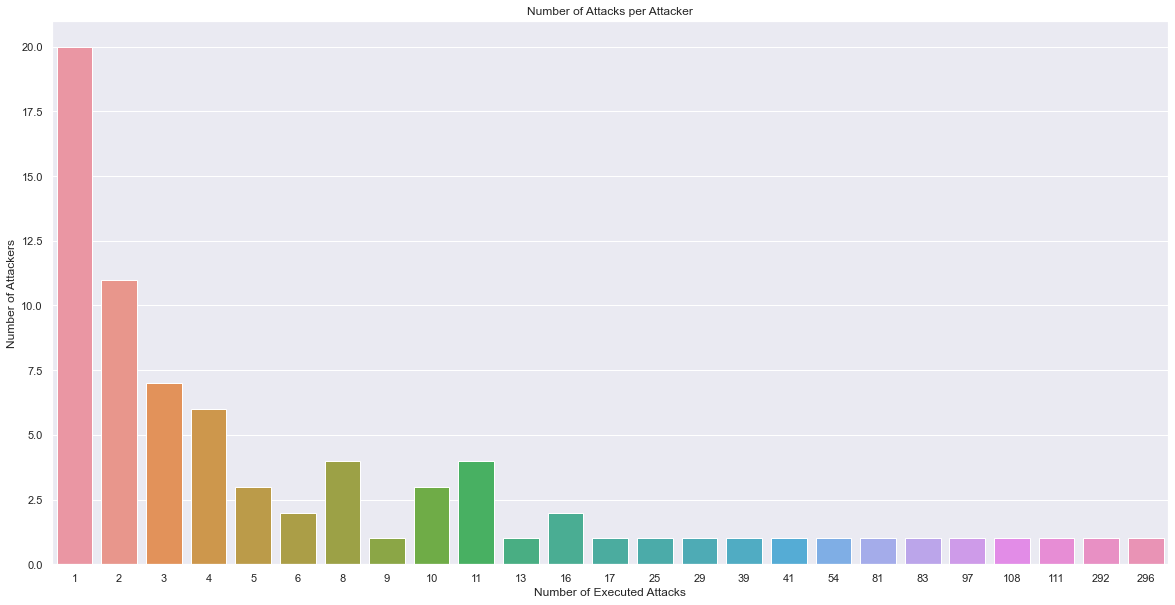

In [27]:
hF, hA = plt.subplots(figsize = (20, 10)) # 
sns.countplot(dsAttacksAsset, ax = hA)
hA.set_title('Number of Attacks per Attacker')
hA.set_xlabel('Number of Executed Attacks')
hA.set_ylabel('Number of Attackers')

In [28]:
# How many times each asset was attacked?
dsSenderCount = dfData[dfData['Label'] == 1]['Sender ID'].value_counts()

Text(0, 0.5, 'Number of Assets')

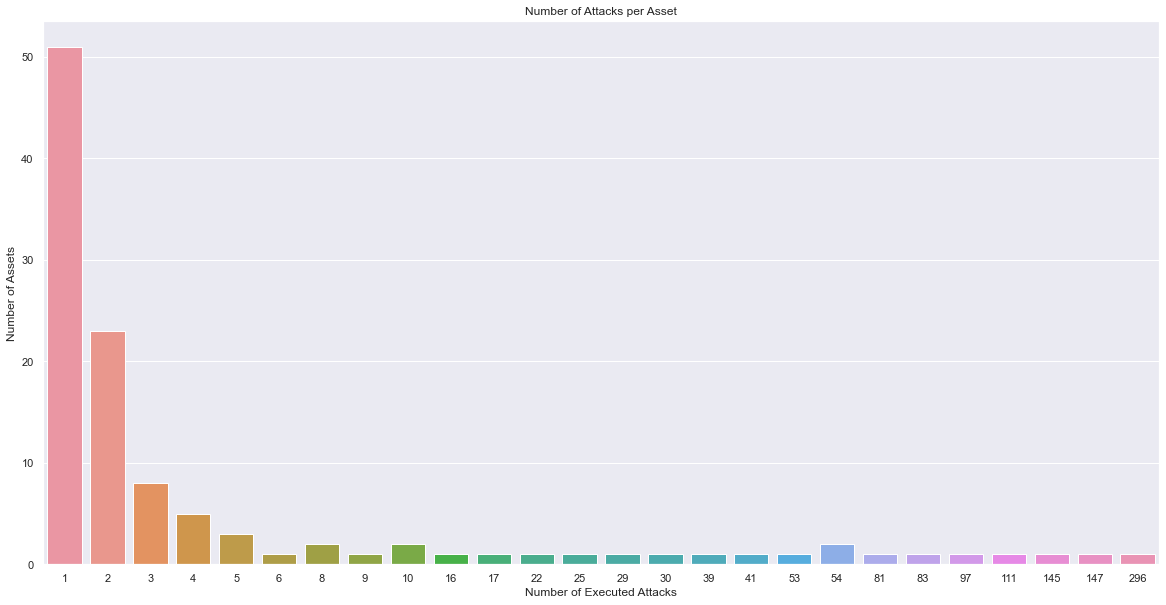

In [29]:
hF, hA = plt.subplots(figsize = (20, 10)) # TODO: Display an histogram (How many assets were attacked 1, 2, ...)
sns.countplot(dsSenderCount, ax = hA)
hA.set_title('Number of Attacks per Asset')
hA.set_xlabel('Number of Executed Attacks')
hA.set_ylabel('Number of Assets')

In [30]:
# How many different assets each attacker attacked? How many times per asset?
dsAttacksIdAttacker = dfData[dfData['Label'] == 1].groupby(['Receiver ID', 'Sender ID'])['Transaction ID'].count().reset_index(name = 'Number of Attacks')  
dsAttacksIdAttacker.head(40)

,Receiver ID,Sender ID,Number of Attacks
0,0x00000b20f0f6a3a212aa6b85106709cd5941457c,0xe7f445b93eb9cdabfe76541cc43ff8de930a58e6,4
1,0x0333e323e61aa8afa38a1623604a165dcb9f4fec,0xe30dc9b3c29534e9b4e9a166c2f44411163ad59f,4
2,0x04786aada9deea2150deab7b3b8911c309f5ed90,0x40b9b889a21ff1534d018d71dc406122ebcf3f5a,11
3,0x079667f4f7a0b440ad35ebd780efd216751f0758,0x5dbcf33d8c2e976c6b560249878e6f1491bca25c,1
4,0x07e02088d68229300ae503395c6536f09179dc3e,0xa35cf3bdf58ef1ce6a9657659ebe4cd8b491f2ce,1
5,0x07e02088d68229300ae503395c6536f09179dc3e,0xc5ac25cfc2b8284e84ca47dad21cf1319f732c11,2
6,0x098b716b8aaf21512996dc57eb0615e2383e2f96,0x1a2a1c938ce3ec39b6d47113c7955baa9dd454f2,3
7,0x0ae1554860e51844b61ae20823ef1268c3949f7c,0x7ea2be2df7ba6e54b1a9c70676f668455e329d29,1
8,0x0b283b107f70d23250f882fbfe7216c38abbd7ca,0x478c070341265d5fc563512ad7c9c6481a4a3a24,1
9,0x0b283b107f70d23250f882fbfe7216c38abbd7ca,0x6a14fdcbf6fec2f7221b54536279932582f9964c,1


### SASA vs. SAMA Cases

Definitions:

 * SASA:
 * SAMA:

In [31]:
len(dfData[dfData['Label'] == 1]['Receiver ID'].unique())

77

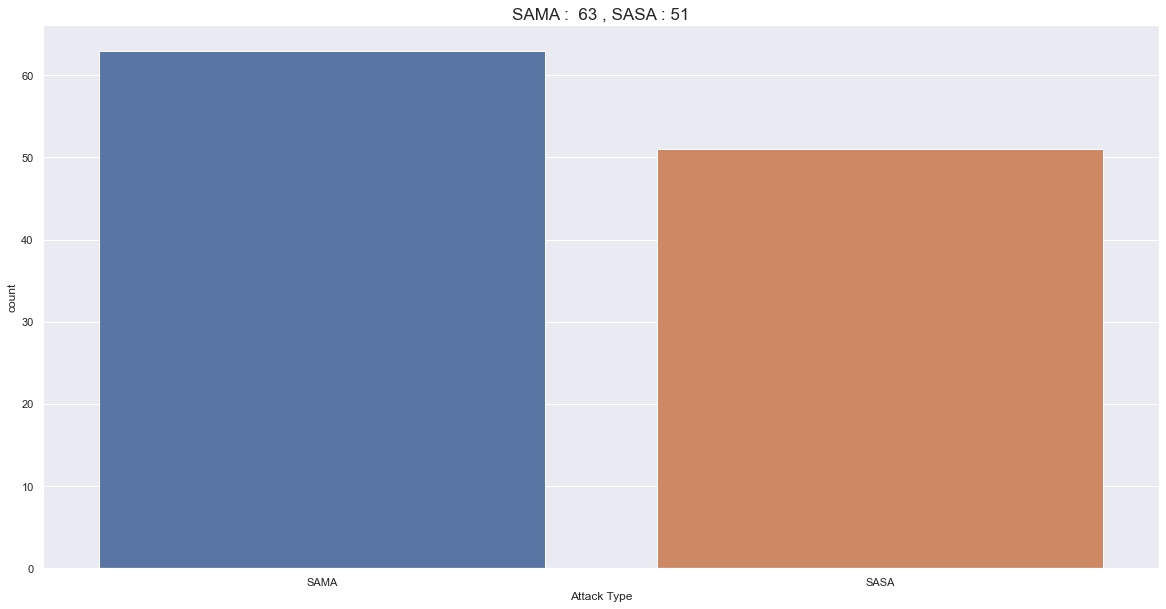

In [32]:
dfSasaSama, lone_attackers_ids, non_lone_attackers_ids = sasa_sama_analysis(dfData)

## Feature Engineering

This section adds features and engineers them.  
Most features work on the `Sender ID` group.

#### Amount Based Features:

1. The STD of the user vs the average STD of all other users of the asset.
2. The Median of the user vs the average STD of all other users of the asset.
3. 

#### Date Based Features

1. The day of the week.
2. Weekend.
3. Hour of the day.
4. STD fo the time difference of the user vs. the avergae of all other users.
5. Median fo the time difference of the user vs. the avergae of all other users.

**Remark**: For wallets with a lot of activity we need to analyze the "activity hours" and profile it.


The features are:

 1. Day of the Week.

Remarks:

 *  Features x-y are time / frequency related.
 *  Features z-t are trasnaction realted.


In [33]:
# Pre Process

dfGbs = GrpBySender(dfData)

In [35]:
sum_s       = dfGbs._SentValue(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_SUM)
sum_s_t     = dfGbs._SentValue_new(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_SUM)
sum_s_t_n   = dfGbs._SentValue_new_numba(amountCol = AmountType.AMOUNT_USD, calcType = CalcType.TYPE_SUM)
#mean_s      = dfGbs._SentValue(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_MEAN)
#mean_s_t    = dfGbs._SentValue_new(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_MEAN)

Function '_SentValue' executed in 0.3559 seconds
Function '_SentValue_new' executed in 0.3693 seconds
Function '_SentValue_new_numba' executed in 0.3958 seconds


In [36]:
(sum_s == sum_s_t).value_counts() , (sum_s == sum_s_t_n).value_counts() #, (mean_s == mean_s_t).value_counts()

(True    609175
 dtype: int64,
 True    609175
 dtype: int64)

In [ ]:
td_mean_s   = dfGbs._SentValue(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_mean_s_t   = dfGbs._SentValue_time_diffs(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs._SentValue(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_std_s_t    = dfGbs._SentValue_time_diffs(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
(td_mean_s == td_mean_s_t).value_counts() , (td_std_s == td_std_s_t).value_counts()

In [ ]:
# Features - Amount Based
'''    TYPE_SUM     TYPE_MEAN            TYPE_STD              TYPE_VAR                    TYPE_MEDIAN           TYPE_COUNT                  TYPE_MIN              TYPE_MAX                    '''
sum_s       = dfGbs._SentValue(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s      = dfGbs._SentValue(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s       = dfGbs._SentValue(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_STD)
var_s       = dfGbs._SentValue(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_VAR)
median_s    = dfGbs._SentValue(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s     = dfGbs._SentValue(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s       = dfGbs._SentValue(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_MIN)
max_s       = dfGbs._SentValue(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_MAX)

dfData[SUM_ASSET]     = sum_s
dfData[MEAN_ASSET]    = mean_s
dfData[STD_ASSET]     = std_s
dfData[VAR_ASSET]     = var_s
dfData[MEDIAN_ASSET]  = median_s
dfData[COUNT_ASSET]   = count_s
dfData[MIN_ASSET]     = min_s
dfData[MAX_ASSET]     = max_s

In [ ]:
# Features - Time Based
'TYPE_TIME_DIFF_MEAN      TYPE_TIME_DIFF_STD TYPE_TIME_DIFF_MEDIAN  TYPE_TIME_DIFF_MIN      TYPE_TIME_DIFF_MAX'      
td_mean_s   = dfGbs._SentValue(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs._SentValue(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs._SentValue(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs._SentValue(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs._SentValue(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[TD_MEAN_ASSET]   = td_mean_s
dfData[TD_STD_ASSET]    = td_std_s
dfData[TD_MEDIAN_ASSET] = td_median_s
dfData[TD_MIN_ASSET]    = td_min_s
dfData[TD_MAX_ASSET]    = td_max_s

In [ ]:
# Features - Time Based

dfData['Hour']      = dfData['Transaction Time'].dt.hour
dfData['Weekday']   = dfData['Transaction Time'].dt.dayofweek

In [ ]:
mean_s         = dfGbs._AnalyseRecieverId(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEAN)
mean_s_t       = dfGbs._AnalyseRecieverId_new(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEAN)
#mean_s_t      = dfGbs._AnalyseRecieverId_new(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEAN)
mean_s_t_numba = dfGbs._AnalyseRecieverId_new_numba(amountCol = AmountType.AMOUNT_USD, calcType = CalcType.TYPE_SUM)
#td_mean_s     = dfGbs._AnalyseRecieverId(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
#td_mean_s_t   = dfGbs._AnalyseRecieverId_time_diffs(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)

In [ ]:
(mean_s == mean_s_t).value_counts() , (mean_s == mean_s_t_numba).value_counts() #, (td_mean_s == td_mean_s_t).value_counts()

In [ ]:
# Features - Amount Based (User)
'''    TYPE_SUM     TYPE_MEAN            TYPE_STD              TYPE_VAR                    TYPE_MEDIAN           TYPE_COUNT                  TYPE_MIN              TYPE_MAX                    '''
sum_s       = dfGbs._AnalyseRecieverId(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s      = dfGbs._AnalyseRecieverId(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s       = dfGbs._AnalyseRecieverId(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_STD)
var_s       = dfGbs._AnalyseRecieverId(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_VAR)
median_s    = dfGbs._AnalyseRecieverId(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s     = dfGbs._AnalyseRecieverId(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s       = dfGbs._AnalyseRecieverId(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)
max_s       = dfGbs._AnalyseRecieverId(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)

dfData[SUM_USR]     = sum_s
dfData[MEAN_USR]    = mean_s
dfData[STD_USR]     = std_s
dfData[VAR_USR]     = var_s
dfData[MEDIAN_USR]  = median_s
dfData[COUNT_USR]   = count_s
dfData[MIN_USR]     = min_s
dfData[MAX_USR]     = max_s

In [ ]:
# Features - Time Based (User)
'TYPE_TIME_DIFF_MEAN      TYPE_TIME_DIFF_STD TYPE_TIME_DIFF_MEDIAN  TYPE_TIME_DIFF_MIN      TYPE_TIME_DIFF_MAX'      
td_mean_s   = dfGbs._AnalyseRecieverId(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs._AnalyseRecieverId(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs._AnalyseRecieverId(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs._AnalyseRecieverId(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs._AnalyseRecieverId(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[TD_MEAN_USR]   = td_mean_s
dfData[TD_STD_USR]    = td_std_s
dfData[TD_MEDIAN_USR] = td_median_s
dfData[TD_MIN_USR]    = td_min_s
dfData[TD_MAX_USR]    = td_max_s

In [ ]:
#what we need it this 2 columns:
#Amount STD [USR] - The STD of the amount of the user (Only the transactions of the specific user vs. the specific asset). For SASA cases it will be NaN.
#Average Amount STD [USR] - The average of the STD of all user within a single asset. Pay attention to use mean() which doesn't include NaN.
#Classifiers will compare those 2. You may add a column about the ratio between the 2.
### You may also do a scatter plot of `Amount STD [USR]` vs. `Average Amount STD [USR]` instaed of teh ratio.

### simply df output:
#dfData.groupby(['Receiver ID' , 'Sender ID'])[D_AMOUNT_TYPE_COL_NAME[AmountType.AMOUNT_USD]].std().reset_index(name = 'Amount STD [USR]' )
#oo_ = dfData.groupby(['Receiver ID' , 'Sender ID'])[D_AMOUNT_TYPE_COL_NAME[AmountType.AMOUNT_USD]].std().reset_index(name = 'Amount STD [USR]' ) #[233879 rows x 3 columns]  (643420, 26)
#oo_['Amount STD [USR]'].max() ## <--- 302 919 513.82767344




########
#gr_df = dfData.groupby(['Receiver ID' , 'Sender ID'])[D_AMOUNT_TYPE_COL_NAME[AmountType.AMOUNT_USD]].std().reset_index(level = 1) #df.groupby(['a','b']).size().reset_index(level=1)
#user_std_dict = {k : dict(g.values) for k, g in gr_df.groupby(level = 0)}
#dfData['Amount STD [USR]'] =  dfData.apply(lambda x: user_std_dict[x['Receiver ID']][x['Sender ID']], axis = 1) 




######### Average Amount STD [USR] - The average of the STD of all user within a single asset. Pay attention to use mean() which doesn't include NaN.
#dfData.groupby(['Sender ID','Receiver ID'])['Amount STD [USR]' ].mean().reset_index(name = 'Average Amount STD [USR]') #### <<---- incorrect !!!!!!!!!!!

##### produce df to verify:
#dfData.groupby(['Sender ID'])['Amount STD [USR]' ].mean().reset_index(name = 'Average Amount STD [USR]')

#av_std_dct = dfData.groupby(['Sender ID'], as_index = False)['Amount STD [USR]'].agg('mean').set_index('Sender ID').to_dict()['Amount STD [USR]']
#dfData['Average Amount STD [USR]'] =  dfData.apply(lambda x: av_std_dct[x['Sender ID']], axis = 1)

#TODO: Probably do a sainty check vs. dfData['Amount STD [USR]'].isnull().sum() and (dfData.groupby('Receiver ID')['Transaction ID'].count() == 1).sum()



In [ ]:
#dfData
#dfData[(dfData['Receiver ID'] == '0x0000000000000000000000000000000000000000') & (dfData['Sender ID'] == '0x3ee18b2214aff97000d974cf647e7c347e8fa585') ]

In [ ]:
### plot newly created features
x = dfData[['Amount STD [USR]', 'Average Amount STD [USR]']].to_numpy()
y = dfData['Label'].to_numpy()

d2_plot(x, y ,str1 = "Amount STD [USR]", str2 = "Average Amount STD [USR]")

# Royi: Somehting is strange here, We have transactions with 1e22 / 1e23 values? It is probably more the the whole money in the world :-).

In [ ]:
#### Time interval calculations for groups-subgroups
# need to do approximately this:
## dfData.groupby(['Sender ID','Receiver ID'])['Transaction Time'].apply(lambda x: (x.max() - x.min())/ np.timedelta64(1, 's')).shape

ds_SentValue = pd.Series(index = dfGbs.dfData.index)
for ii in range(len(dfGbs.lSubGrpUsrLabelIdx)):
    for i in range(len(dfGbs.lSubGrpUsrLabelIdx[ii])):
        ival = dfGbs.dfData['Transaction Time'][dfGbs.lSubGrpUsrLabelIdx[ii][i][0]]
        dd = (ival.max() - ival.min()) / np.timedelta64(1, 's')
        ds_SentValue[dfGbs.lSubGrpUsrLabelIdx[ii][i][0]] =  dd
dfData['Time Interval'] = ds_SentValue
#### probably should be added to methods file

# dfData['Max Time (User)'] = dfGbs._AnalyseRecieverId(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)
# dfData['Min Time (User)'] = dfGbs._AnalyseRecieverId(amountCol = AmountType.AMOUNT_USD, tokenId = None, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
# dfData['Time Interval'] = (dfData['Max Time (User)'] - dfData['Min Time (User)']).dt.total_seconds()


In [ ]:
dfData.columns

In [ ]:
# Feature PPS

# Everything: Don't Use!
#lSlctdFeatures = ['Currency Hash', 'Amount [USD]',
#       'Receiver Type', 'SUM (Asset)', 'MEAN (Asset)', 'STD (Asset)',
#       'VAR (Asset)', 'MEDIAN (Asset)', 'COUNT (Asset)', 'MIN (Asset)',
#       'MAX (Asset)', 'TD_MEAN (Asset)', 'TD_STD (Asset)', 'TD_MEDIAN (Asset)',
#       'TD_MIN (Asset)', 'TD_MAX (Asset)', 'Hour', 'Weekday',
#       'Amount STD [USR]', 'Average Amount STD [USR]', 'Time Interval',
#       'SUM (User)', 'MEAN (User)', 'STD (User)', 'MEDIAN (User)', 'COUNT (User)',
#       'MIN (User)', 'MAX (User)', 'TD_MEAN (User)', 'TD_STD (User)', 'TD_MEDIAN (User)',
#       'TD_MIN (User)', 'TD_MAX (User)']

lSlctdFeatures = ['Amount [USD]', 'TD_MEAN (Asset)', 'TD_STD (Asset)', 'TD_MEDIAN (Asset)',
       'TD_MIN (Asset)', 'TD_MAX (Asset)', 'Hour', 'Weekday', 'Time Interval',
       'SUM (User)', 'MEAN (User)', 'STD (User)', 'MEDIAN (User)',   'TD_MAX (User)']

numFeatures = len(lSlctdFeatures)
mPPS = pps.matrix(dfData[lSlctdFeatures + ['Label']], **{'cross_validation': 20, 'random_seed': 1234})[['x', 'y', 'ppscore']].pivot(columns = 'x', index = 'y', values = 'ppscore')
# Visualization of PPS
hF, hA = plt.subplots(figsize = (30, 30))
sns.heatmap(mPPS, annot = True, fmt = '.2f', cmap = plt.get_cmap('coolwarm'), cbar = False, vmin = 0, vmax = 1, ax = hA) 

plt.setp(hA.get_xticklabels(), ha = "center", rotation = 45)
plt.setp(hA.get_yticklabels(), rotation = 'horizontal')
hA.set_title('Predictive Power Score (PPS)')

In [ ]:
####################### create inputs for ML algos:
dfData.fillna(0, inplace=True)
X = dfData[dfData.columns[~dfData.columns.isin(['Transaction ID', 'Transaction Time', 'Sender ID', 'Receiver ID', 'Currency', 'Currency Hash', 'Currency Type', 'Receiver Type','tx_hash','Label'])]].to_numpy()
Y = dfData['Label'].to_numpy()
#Y = Y.reshape(-1,1)
sc = StandardScaler()
X_scaled = sc.fit_transform(X)


In [ ]:
lSlctdFeatures_num = ['Amount [USD]', 'SUM (Asset)', 'MEAN (Asset)', 'STD (Asset)',      'VAR (Asset)', 'MEDIAN (Asset)', 'COUNT (Asset)', 'MIN (Asset)',
      'MAX (Asset)', 'TD_MEAN (Asset)', 'TD_STD (Asset)', 'TD_MEDIAN (Asset)',
       'TD_MIN (Asset)', 'TD_MAX (Asset)', 'Hour', 'Weekday', 'Time Interval',
       'SUM (User)', 'MEAN (User)', 'STD (User)', 'MEDIAN (User)', 'COUNT (User)',
       'MIN (User)', 'MAX (User)', 'TD_MEAN (User)', 'TD_STD (User)', 'TD_MEDIAN (User)',
       'TD_MIN (User)', 'TD_MAX (User)']  
normal = dfData[dfData.Label==0]
fraud = dfData[dfData.Label==1]
sample_size = len(fraud)
significant_features = []
critical_value = 2.58

for i in lSlctdFeatures_num:
    
    z_vavlue = ztest(i, normal, fraud,sample_size)
    
    if( abs(z_vavlue) >= critical_value):    
        print(i," is statistically significant") #Reject Null hypothesis. i.e. H0
        significant_features.append(i)
#hour  is statistically significant , weekday  is statistically significant, Time interval  is statistically significant, COUNT  is statistically significant, TD_MEAN  is statistically significant
#TD_STD  is statistically significant , TD_MAX  is statistically significant

# Features Visualization



In [ ]:
sns.countplot(dfData.Label)
plt.show()
print(dfData.Label.value_counts())

In [ ]:
# Visualize Data & Features (Anton)
### check if there is hour dependency(clearly for fraud cases there is some dependency) 
plt.figure(figsize=(12,5))
sns.distplot(dfData[dfData['Label'] == 0]["Hour"], color='g')
sns.distplot(dfData[dfData['Label'] == 1]["Hour"], color='r')
plt.title('Fraud and Normal Transactions by Hours', fontsize=17)
plt.xlim([-1,25])
plt.show()


plt.figure(figsize=(12,5))
sns.distplot(dfData[dfData['Label'] == 0]["Weekday"], color='g')
sns.distplot(dfData[dfData['Label'] == 1]["Weekday"], color='r')
plt.title('Fraud and Normal Transactions by weekdays (0 - Monday)', fontsize=17)
plt.xlim([-1,8])
plt.show()

In [ ]:
#columns = df.drop('Class', axis=1).columns
feat_to_plot  = ['Amount [USD]', 'SUM (Asset)', 'MEAN (Asset)', 'STD (Asset)',      'VAR (Asset)', 'MEDIAN (Asset)', 'COUNT (Asset)', 'MIN (Asset)',
      'MAX (Asset)', 'TD_MEAN (Asset)', 'TD_STD (Asset)', 'TD_MEDIAN (Asset)',
       'TD_MIN (Asset)', 'TD_MAX (Asset)', 'Hour', 'Weekday', 'Time Interval',
       'SUM (User)', 'MEAN (User)', 'STD (User)', 'MEDIAN (User)', 'COUNT (User)',
       'MIN (User)', 'MAX (User)', 'TD_MEAN (User)', 'TD_STD (User)', 'TD_MEDIAN (User)',
       'TD_MIN (User)', 'TD_MAX (User)']
grid = gridspec.GridSpec(4, 4)

plt.figure(figsize=(20, 10 * 2))

for n, col in enumerate(dfData[feat_to_plot]):
    ax = plt.subplot(grid[n])
    sns.distplot(dfData[dfData.Label==1][col], bins = 50, color='g')
    sns.distplot(dfData[dfData.Label==0][col], bins = 50, color='r') 
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
    
plt.show()

In [ ]:
g = sns.pairplot(dfData[['Hour', 'Weekday', 'Time Interval', 'Amount [USD]', 'TD_MEAN (User)', 'TD_STD (User)', 'Label']], hue = "Label", diag_kind = 'kde')


# Dimensionality Reduction

Using LDA, QDA and T-SNE

In [ ]:
# # LDA & QDA (Anton)
# # LDA & QDA (Anton)

# ################################################################
# ### Straight forward dimensionality reduction using LDA is very limited as n_components cannot be larger than min(n_features, n_classes - 1)
# ### consequently in a situation of binary classification we face the problem that all the features have to collapse to only one.
# ### for example :
# #lda = LDA(n_components=2)
# #X_lda = lda.fit_transform(X, Y)
# ### will lead to a crash

# lda = LDA(n_components=1)
# X_lda = lda.fit_transform(X, Y) # X_lda becomes 1-dimensional


# ##### illustrative case of LDA dimensionality reduction usage, i artificially add 3rd class, corrupting original data, but it gives a chance to better see the resulting data
# x = X_scaled ; y = Y

# #number_of_rows = x.shape[0]
# #random_indices = np.random.choice(number_of_rows, size=100000, replace=False)
# #x = x[random_indices, :]; #y = y[random_indices]
# y[-7:-1] = 2 
# lda = LDA(n_components=2)
# x_lda = lda.fit(x, y).transform(x)

# d2_plot(x_lda,y ,str1 = "lda1" ,str2 = "lda2" )

In [ ]:
# # T-SNE (Anton)
# #### takes forever............. actually 37 mins :)
# if runTsne:
#     x = X_scaled ; y = Y

#     # use below lines for quick try
#     #number_of_rows = x.shape[0]
#     #random_indices = np.random.choice(number_of_rows, size=5000, replace=False)
#     #x = x[random_indices, :]
#     #y = y[random_indices]


#     tsne = TSNE(n_components=2, verbose=1, random_state=123)
#     z = tsne.fit_transform(x)
#     df = pd.DataFrame()
#     df["y"] = y
#     df["comp-1"] = z[:,0]
#     df["comp-2"] = z[:,1]

#     sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
#                 #palette=sns.color_palette("hls", 2),
#                 data=df).set(title="T-SNE projection")


## Supervised Classification

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = testSetRatio, random_state = 42) #<! Royi: You should use startified split as the data is imbalanced
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = testSetRatio, random_state = 42 , stratify = Y)

In [ ]:
#model = XGBClassifier(use_label_encoder = False)#model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
#model.fit(X_train, y_train)
#y_pred_xgboost = model.predict(X_test)
#print_scores(y_pred_xgboost, y_test)

In [ ]:
dfData_ = dfData.copy(deep=True)

In [ ]:
def ml_input_create(dfData, dAssetFile, categor_cols, num_cols , test_train_selection_proportion_ , dfSasaSama,  selection_option = 'file_selection', use_categorical = True):
    
    dfData[dfData.columns[~dfData.columns.isin(['Transaction ID', 'Transaction Time', 'Sender ID', 'Receiver ID',  'Currency Hash','tx_hash', 'Currency',  'Currency Type', 'Receiver Type','Label'])]].fillna(0, inplace=True) 
    #dfData.fillna(0, inplace=True)
    ####################### create inputs for ML algos:
    #### get ids of cases attributed to files, then randomly select ids for train and test subsets

    sasa_asset_ids = dfSasaSama[dfSasaSama[attackTypeColName] == 'SASA']['Sender ID'].to_list()
    sama_asset_ids = dfSasaSama[dfSasaSama[attackTypeColName] == 'SAMA']['Sender ID'].to_list()

    if selection_option == 'file_selection':
        all_ids = list(dAssetFile.keys()) 
        rnd_choices_train = random.choices(all_ids, k = int(test_train_selection_proportion_*len(all_ids)))
        
        rnd_choices_test = list(set(all_ids) - set(rnd_choices_train)) + list(set(rnd_choices_train) - set(all_ids))

        for cat_col in categor_cols:
            dfData[cat_col] = dfData[cat_col].astype("category", copy = False)
            
        scaler = StandardScaler()

        dfData[num_cols] = scaler.fit_transform(dfData[num_cols])

        
                
        dfData_train = dfData[dfData['Sender ID'].isin(rnd_choices_train)]
        dfData_test = dfData[dfData['Sender ID'].isin(rnd_choices_test)]
        
        
        if use_categorical:
            X_train = dfData_train[dfData_train.columns[~dfData_train.columns.isin(['Transaction ID', 'Transaction Time', 'Sender ID', 'Receiver ID',  'Currency Hash','tx_hash','Label'])]]
            X_train.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
            Y_train = dfData_train['Label']
        
            X_test = dfData_test[dfData_train.columns[~dfData_test.columns.isin(['Transaction ID', 'Transaction Time', 'Sender ID', 'Receiver ID',  'Currency Hash','tx_hash','Label'])]]
            X_test.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
            Y_test = dfData_test['Label']
            
            X_test_sasa = dfData_test[dfData_train.columns[~dfData.columns.isin(['Transaction ID', 'Transaction Time', 'Sender ID', 'Receiver ID',  'Currency Hash','tx_hash','Label'])]][dfData_test['Sender ID'].isin(sasa_asset_ids)]
            X_test_sasa.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
            Y_test_sasa = dfData_test['Label'][dfData_test['Sender ID'].isin(sasa_asset_ids)]
        
            X_test_sama = dfData_test[dfData_train.columns[~dfData.columns.isin(['Transaction ID', 'Transaction Time', 'Sender ID', 'Receiver ID',  'Currency Hash','tx_hash','Label'])]][dfData_test['Sender ID'].isin(sama_asset_ids)]
            X_test_sama.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
            Y_test_sama = dfData_test['Label'][dfData_test['Sender ID'].isin(sama_asset_ids)]

        else:
            X_train = dfData_train[dfData_train.columns[~dfData_train.columns.isin(['Transaction ID', 'Transaction Time', 'Sender ID', 'Receiver ID', 'Currency', 'Currency Hash', 'Currency Type', 'Receiver Type','tx_hash','Label'])]]
            X_train.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
            Y_train = dfData_train['Label']
        
            X_test = dfData_test[dfData_train.columns[~dfData_test.columns.isin(['Transaction ID', 'Transaction Time', 'Sender ID', 'Receiver ID', 'Currency', 'Currency Hash', 'Currency Type', 'Receiver Type','tx_hash','Label'])]]
            X_test.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
            Y_test = dfData_test['Label']
            
            X_test_sasa = dfData_test[dfData_train.columns[~dfData.columns.isin(['Transaction ID', 'Transaction Time', 'Sender ID', 'Receiver ID', 'Currency', 'Currency Hash', 'Currency Type', 'Receiver Type','tx_hash','Label'])]][dfData_test['Sender ID'].isin(sasa_asset_ids)]
            Y_test_sasa = dfData_test['Label'][dfData_test['Sender ID'].isin(sasa_asset_ids)]
        
            X_test_sama = dfData_test[dfData_train.columns[~dfData.columns.isin(['Transaction ID', 'Transaction Time', 'Sender ID', 'Receiver ID', 'Currency', 'Currency Hash', 'Currency Type', 'Receiver Type','tx_hash','Label'])]][dfData_test['Sender ID'].isin(sama_asset_ids)]
            Y_test_sama = dfData_test['Label'][dfData_test['Sender ID'].isin(sama_asset_ids)]    

   
    if selection_option == 'simple_selection':
               
        dfData_train, dfData_test = train_test_split(dfData, test_size=(1 - test_train_selection_proportion_), random_state=0, stratify=dfData[['Label']])

        #X_train = dfData[dfData.columns[~dfData.columns.isin(['Transaction ID', 'Transaction Time', 'Sender ID', 'Receiver ID', 'Currency', 'Currency Hash', 'Currency Type', 'Receiver Type','tx_hash','Label'])]].to_numpy()
        X_train = dfData_train[dfData_train.columns[~dfData_train.columns.isin(['Transaction ID', 'Transaction Time', 'Sender ID', 'Receiver ID', 'Currency', 'Currency Hash', 'Currency Type', 'Receiver Type','tx_hash','Label'])]]
        X_train.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
        Y_train = dfData_train['Label']
    
        X_test = dfData_test[dfData_train.columns[~dfData.columns.isin(['Transaction ID', 'Transaction Time', 'Sender ID', 'Receiver ID', 'Currency', 'Currency Hash', 'Currency Type', 'Receiver Type','tx_hash','Label'])]]
        X_test.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
        Y_test = dfData_test['Label']
        
        X_test_sasa = dfData_test[dfData_train.columns[~dfData.columns.isin(['Transaction ID', 'Transaction Time', 'Sender ID', 'Receiver ID', 'Currency', 'Currency Hash', 'Currency Type', 'Receiver Type','tx_hash','Label'])]][dfData_test['Sender ID'].isin(sasa_asset_ids)]
        Y_test_sasa = dfData_test['Label'][dfData_test['Sender ID'].isin(sasa_asset_ids)]
       
        X_test_sama = dfData_test[dfData_train.columns[~dfData.columns.isin(['Transaction ID', 'Transaction Time', 'Sender ID', 'Receiver ID', 'Currency', 'Currency Hash', 'Currency Type', 'Receiver Type','tx_hash','Label'])]][dfData_test['Sender ID'].isin(sama_asset_ids)]
        Y_test_sama = dfData_test['Label'][dfData_test['Sender ID'].isin(sama_asset_ids)]
        #Y = dfData['Label'].to_numpy()
    
        #sc = StandardScaler()
        #X_scaled = sc.fit_transform(X)
        #X_train, X_test, Y_train, Y_test = train_test_split( X_scaled, Y, test_size=test_train_selection_proportion_, random_state=42) #<! Royi: You should use startified split as the data is imbalanced

    return X_train, Y_train, X_test, Y_test , X_test_sasa, Y_test_sasa, X_test_sama, Y_test_sama


    

In [ ]:
@timer
def model_train(x,y,eval = None, model_ = 'xgboost'):
    if model_ == 'xgboost':
        model = XGBClassifier(tree_method="gpu_hist", enable_categorical=True)#use_label_encoder=False,#model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
        model.fit(x, y)
    if model_ == 'svm':
        model = SVC(kernel='linear')
        model.fit(x, y)

    if model_ == 'nn':
        n_vars = x.shape[1]
        model = MLPClassifier(solver='lbfgs', alpha=1e-5,  hidden_layer_sizes=(n_vars, 2*n_vars), random_state=1)
        model.fit(x, y)
    
    if model_ == 'catboost':
        train_data = cb.Pool(x, y, cat_features=['Currency', 'Currency Type', 'Receiver Type']) 
        eval_data = eval
        model = CatBoostClassifier(iterations=10)
        model.fit(train_data, eval_set=eval_data)
            

    return model



@timer
def model_inference(x, model):#, model_ = 'xgboost'):
    return model.predict(x)    

In [ ]:
def k_fold_training(k_fold, dfData, dAssetFile, categor_cols, num_cols , test_train_selection_proportion_ ,dfSasaSama ,selection_option = 'file_selection', model_ = 'xgboost'):


    max = 0 ; r = []
    for i in range(k_fold):
        
        if model_ == 'xgboost':
            X_train, Y_train, X_test, Y_test , X_test_sasa, Y_test_sasa, X_test_sama, Y_test_sama = ml_input_create(dfData, dAssetFile, categor_cols, num_cols , test_train_selection_proportion_ ,dfSasaSama ,selection_option = selection_option, use_categorical = True)
            model = model_train(X_test, Y_test,eval = None, model_ = 'xgboost')
            y_pred_xgboost = model_inference(X_test, model)#y_pred_xgboost = model.predict(X_test)
            
            _, _, f1_score = model_scores(y_pred_xgboost, Y_test)
            if f1_score > max : 
                max = f1_score
                r = [max, model]
            
        
        if model_ == 'svm':
            
            X_train, Y_train, X_test, Y_test , X_test_sasa, Y_test_sasa, X_test_sama, Y_test_sama = ml_input_create(dfData, dAssetFile, categor_cols, num_cols , test_train_selection_proportion_ ,dfSasaSama ,selection_option = selection_option, use_categorical = False)
            model = model_train(X_test, Y_test,eval = None, model_ = 'svm')
            y_pred = model_inference(X_test, model) #y_pred = model.predict(X_test)

            
            _, _, f1_score = model_scores(y_pred, Y_test)
            if f1_score > max : 
                max = f1_score
                r = [max, model]
            
        if model_ == 'catboost':
            X_train, Y_train, X_test, Y_test , X_test_sasa, Y_test_sasa, X_test_sama, Y_test_sama = ml_input_create(dfData, dAssetFile, categor_cols, num_cols , test_train_selection_proportion_ ,dfSasaSama ,selection_option = selection_option, use_categorical = True)
            #train_data = cb.Pool(X_train, Y_train, cat_features=['Currency', 'Currency Type', 'Receiver Type']) 
            eval_data = cb.Pool(X_test, Y_test, cat_features=['Currency', 'Currency Type', 'Receiver Type'])
            #model = CatBoostClassifier(iterations=10) ;    #model.fit(train_data, eval_set=eval_data)
            model = model_train(X_train,Y_train,eval = eval_data, model_ = 'catboost')
            preds_catboost_y = model_inference(eval_data, model)#preds_catboost_y = model.predict(eval_data)
            #preds_catboost_y = model.predict(X_test)
            
            
            _, _, f1_score = model_scores(preds_catboost_y, Y_test)
            if f1_score > max : 
                max = f1_score
                r = [max, model]

        if model_ == 'nn':
            X_train, Y_train, X_test, Y_test , X_test_sasa, Y_test_sasa, X_test_sama, Y_test_sama = ml_input_create(dfData, dAssetFile, categor_cols, num_cols , test_train_selection_proportion_ ,dfSasaSama ,selection_option = selection_option, use_categorical = False)
            model = model_train(X_test, Y_test,eval = None, model_ = 'nn')
            
            y_nn_pred = model.predict(X_test)    
            _, _, f1_score = model_scores(y_nn_pred, Y_test)
            if f1_score > max : 
                max = f1_score
                r = [max, model]
                    
            
    return r , X_test_sasa, Y_test_sasa, X_test_sama, Y_test_sama    



In [ ]:
#r, X_test_sasa, Y_test_sasa, X_test_sama, Y_test_sama = k_fold_training(20, dfData_, dAssetFile, categor_cols, num_cols , test_train_selection_proportion_ ,dfSasaSama ,selection_option = 'file_selection', model_ = 'xgboost')
#r, X_test_sasa, Y_test_sasa, X_test_sama, Y_test_sama = k_fold_training(10, dfData, dAssetFile, categor_cols, num_cols , test_train_selection_proportion_ ,dfSasaSama ,selection_option = 'file_selection', model_ = 'svm') ### <<-- forever
r, X_test_sasa, Y_test_sasa, X_test_sama, Y_test_sama = k_fold_training(10, dfData_, dAssetFile, categor_cols, num_cols , test_train_selection_proportion_ ,dfSasaSama ,selection_option = 'file_selection', model_ = 'catboost')
print(r)
best_model_ = r[1]
y_pred_sasa = model_inference(X_test_sasa, best_model_)#best_model_.predict(X_test_sasa)
y_pred_sama = model_inference(X_test_sama, best_model_)#best_model_.predict(X_test_sama)

#print_scores(y_pred_xgboost, Y_test)
print('sasa scores : ')
print_scores(y_pred_sasa, Y_test_sasa)
print('sama scores : ')
print_scores(y_pred_sama, Y_test_sama)

In [ ]:
r, X_test_sasa, Y_test_sasa, X_test_sama, Y_test_sama = k_fold_training(10, dfData_, dAssetFile, categor_cols, num_cols , test_train_selection_proportion_ ,dfSasaSama ,selection_option = 'file_selection', model_ = 'xgboost')
print(r)
best_model_ = r[1]
y_pred_sasa = model_inference(X_test_sasa, best_model_)#best_model_.predict(X_test_sasa)
y_pred_sama = model_inference(X_test_sama, best_model_)#best_model_.predict(X_test_sama)

#print_scores(y_pred_xgboost, Y_test)
print('sasa scores : ')
print_scores(y_pred_sasa, Y_test_sasa)
print('sama scores : ')
print_scores(y_pred_sama, Y_test_sama)

In [ ]:
r, X_test_sasa, Y_test_sasa, X_test_sama, Y_test_sama = k_fold_training(2, dfData_, dAssetFile, categor_cols, num_cols , test_train_selection_proportion_ ,dfSasaSama ,selection_option = 'file_selection', model_ = 'nn')

In [ ]:
print(r)
best_model_ = r[1]
y_pred_sasa = model_inference(X_test_sasa, best_model_)#best_model_.predict(X_test_sasa)
y_pred_sama = model_inference(X_test_sama, best_model_)#best_model_.predict(X_test_sama)

#print_scores(y_pred_xgboost, Y_test)
print('sasa scores : ')
print_scores(y_pred_sasa, Y_test_sasa)
print('sama scores : ')
print_scores(y_pred_sama, Y_test_sama)

In [ ]:
@timer
def f():
  s = 0
  for i in range(1000000):
    for k in range(100):
      s = s + i + k
  return s  

f()

In [ ]:
@timer
@numba.jit
def g():
  s = 0
  for i in range(1000000):
    for k in range(100):
      s = s + i + k
  return s
g()  